In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
words=open("names.txt",'r').read().splitlines()

In [7]:
chars=sorted(list(set(''.join(words))))   
stoi={s: i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
block_size=3
def create_dataset(words):
    
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context),'---->',itos[ix])
            context=context[1:]+[ix]

    x=torch.tensor(x)
    y=torch.tensor(y)

    return x,y  

import random 
random.seed(32)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=create_dataset(words[:n1])
xdev,ydev=create_dataset(words[n1:n2])
xte,yte=create_dataset(words[n2:])

In [11]:
n_emb=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647)
c=torch.randn((27,n_emb),generator=g)
w1=torch.randn((n_emb*block_size,n_hidden),generator=g)
b1=torch.randn((n_hidden,),generator=g)
w2=torch.randn((n_hidden,vocab_size),generator=g)
b2=torch.randn((vocab_size,),generator=g)
parameters=[c,w1,b2,w2,b2]
print(sum(p.nelement() for p in parameters))
for i in parameters:
    i.requires_grad=True

11724


In [13]:
max_steps=200000
batch_size=32
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    xb,yb=xtr[ix],ytr[ix]

    emb=c[xb]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@w1+b1 
    h=torch.tanh(hpreact)
    logits=h@w2+b2 
    loss=F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad=None 
    loss.backward()

    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad 
    
    if i %10000==0:
        print(f"{i:7d}/{max_steps:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())

      0/ 200000:28.566628
  10000/ 200000:2.923568
  20000/ 200000:2.517647
  30000/ 200000:2.045563
  40000/ 200000:3.074094
  50000/ 200000:2.270838
  60000/ 200000:2.369227
  70000/ 200000:2.328539
  80000/ 200000:2.223988
  90000/ 200000:2.308862
 100000/ 200000:1.990997
 110000/ 200000:2.083325
 120000/ 200000:2.235340
 130000/ 200000:2.209970
 140000/ 200000:2.208609
 150000/ 200000:2.467054
 160000/ 200000:2.222713
 170000/ 200000:1.908477
 180000/ 200000:2.235825
 190000/ 200000:1.816004


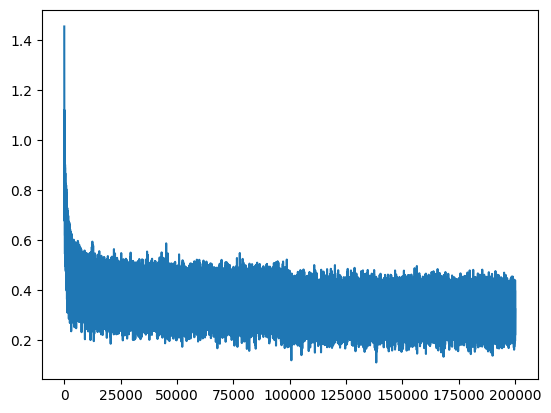

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(xtr,ytr),
        'val':(xdev,ydev),
        'test':(xte,yte),
    }[split]
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    h=torch.tanh(embcat@w1+b1)
    logits=h@w2+b2 
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss("train")
split_loss("val")

train 2.1216323375701904
val 2.1717443466186523


In [23]:
g=torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out=[]
    context=[0]*block_size 
    
    while True:
        emb=c[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1)@w1+b1)
        logits=h@w2+b2 
        probs=F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break 
    print(''.join(itos[i] for i in out))

junide.
jakarie.
presty.
adna.
kaileitoliva.
julem.
damela.
yanilena.
jadeyaileti.
tayseoniely.
arten.
aveumahyfortume.
phyn.
leigh.
ani.
core.
yarion.
kaelandreer.
miki.
wyn.


tensor([[ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070],
        [ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070],
        [ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070]], grad_fn=<IndexBackward0>)

tensor([[ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070],
        [ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070],
        [ 1.6836,  0.7068,  0.5450, -0.7304,  0.8623,  0.1975, -1.3893,  0.7920,
          0.1706,  1.4070]], grad_fn=<IndexBackward0>)